In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_var_hist,simulate_traj, get_p_x4_short_time, get_steady_mean
from setup import setup_matplotlib

setup_matplotlib()

np.random.seed(42)

In [4]:
k = 1
s = 1
D = s**2/2
#N_t = 100
max_t = 6
ntau = 3
dx = 0.2
sb = 20*dx

f = 15
N_p = 16_000


x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

def force(x,*args):
     return -k*x**3

i_zero = np.argmin(x_s**2)

# Deterministic system

In [5]:
det_f = 200
x = np.empty(100000)


def get_con(x0, ntau_t, dt_t ):
    x[:ntau_t] = 0
    x[ntau_t-1] = x0
    for i in range(ntau_t, len(x)):
        x[i] = x[i-1]+force(x[i-ntau_t])*dt_t
    return np.isfinite(x[-1]) and x[-1] < x0

def get_oszi(x0, ntau_t, dt_t ):
    x[:ntau_t] = 0
    x[ntau_t-1] = x0
    for i in range(ntau_t, len(x)):
        x[i] = x[i-1]+force(x[i-ntau_t])*dt_t
    return np.all(x >= 0)


det_ltaus = np.logspace(-2,1,10) #np.arange(0.01,0.21,0.01)
diff_b = []
oszi_b = []


for ltau in det_ltaus:
    x1 = 0.001
    x3 = 60
    
    ntau_t = ntau*det_f
    dt_t = ltau/ntau_t
    
    e1 = get_con(x1, ntau_t, dt_t)
    e3 = get_con(x3, ntau_t, dt_t)
    if not e1 or e3:
        print('Boundarys to small')
    for i in range(10):
        x2 = (x1+x3)/2
        e2 = get_con(x2, ntau_t, dt_t)
        if e2:
            x1 = x2
        else:
            x3 = x2
    diff_b.append((x1+x3)/2)
    
for ltau in det_ltaus:
    x1 = 0.001
    x3 = 60
    
    ntau_t = ntau*det_f
    dt_t = ltau/ntau_t
    
    e1 = get_oszi(x1, ntau_t, dt_t)
    e3 = get_oszi(x3, ntau_t, dt_t)
    if not e1 or e3:
        print('Boundarys to small')
    for i in range(10):
        x2 = (x1+x3)/2
        e2 = get_oszi(x2, ntau_t, dt_t)
        if e2:
            x1 = x2
        else:
            x3 = x2
    oszi_b.append((x1+x3)/2)

/tmp/ipykernel_5129/951007182.py:19: RuntimeWarning: overflow encountered in double_scalars
  return -k*x**3
/tmp/ipykernel_5129/3718311904.py:9: RuntimeWarning: invalid value encountered in double_scalars
  x[i] = x[i-1]+force(x[i-ntau_t])*dt_t
/tmp/ipykernel_5129/3718311904.py:16: RuntimeWarning: invalid value encountered in double_scalars
  x[i] = x[i-1]+force(x[i-ntau_t])*dt_t


Text(0.5, 0, '$\\tau$')

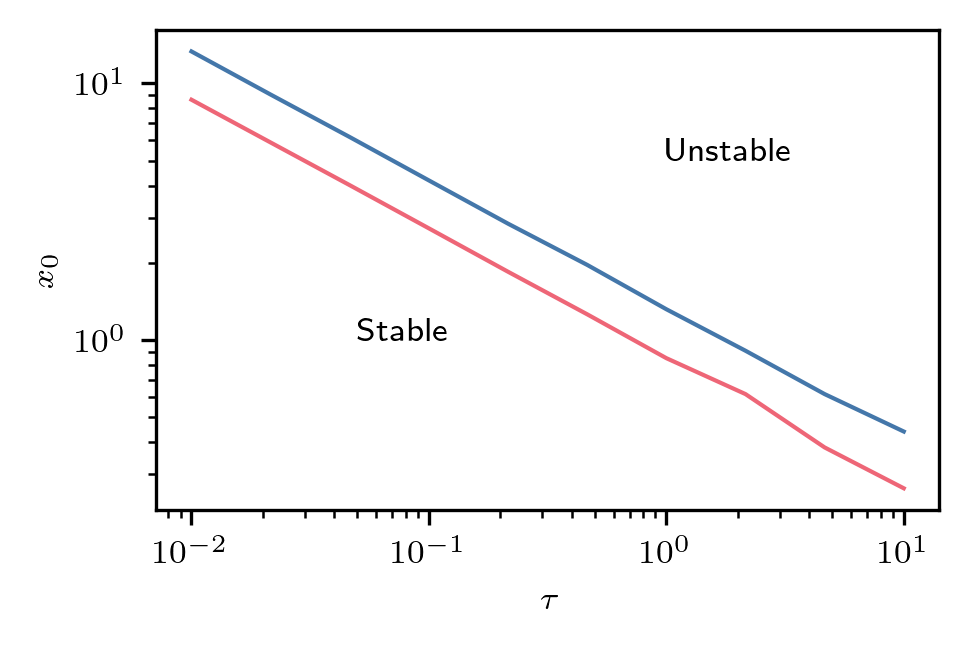

In [6]:
plt.plot(det_ltaus, diff_b)
plt.plot(det_ltaus, oszi_b)
#plt.plot(det_ltaus, 4/3*det_ltaus**(-1/2)) #Why ?? - dif border
#plt.plot(det_ltaus,(6/7)*det_ltaus**(-1/2)) # WHy ?? - in both cases pre factor estimated
plt.text(1,5,'Unstable')
plt.text(0.05,1,'Stable')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$x_0$')
plt.xlabel(r'$\tau$')

# Stochastic system

In [29]:
ltaus = np.concatenate(([0.05], np.arange(0.1,1.1,0.1) ))
sim_vars = np.empty((len(ltaus),2))
num_vars = np.empty((len(ltaus),2))
sim_hist_vars = np.empty((len(ltaus),2))
short_time_approx_var = np.empty(len(ltaus))
escaped_traj = np.empty(len(ltaus))

for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau
    N_t = max(int(max_t/ldt), 30)
    prop = get_prop_abs_v2(x_s, force,D,ldt,dx, side = 'lr')
    R, _, end_states = create_R_v1(N_x, ntau, prop)
    
    _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
    
    
    pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=ldt/f,border=0, force=force)
    all_pos = pos[0]
    sim_hists = [np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]), leave=False)]
 
    sim_var = np.var(pos, axis = 1) # Use only particles which are not on a diverging traj
    sim_hist_var = get_var_hist(sim_hists, x_s)
    
    num_var = get_var_hist(hists, x_s)
    
    short_time_p = get_p_x4_short_time(x_s, k,ltau,s)

    
    escaped_traj[i] = 1-np.sum(sim_hists[-1])/N_p
    
    m_sim_var = get_steady_mean(sim_var)
    sim_vars[i] = m_sim_var if m_sim_var else (np.nan,np.nan)
    
    m_num_var = get_steady_mean(num_var)
    num_vars[i] = m_num_var if m_num_var else (np.nan,np.nan)
    
    m_sim_hist_vars = get_steady_mean(sim_hist_var)
    print(m_sim_hist_vars)
    sim_hist_vars[i] = m_sim_hist_vars if m_sim_hist_vars else (np.nan,np.nan)
    
    short_time_approx_var[i] = get_var_hist(short_time_p, x_s)

    
# with open(f'nummeric_results/sim_vs_num_v4_emb{tau_frac}_x4.pkl', 'wb') as file:
#     pickle.dump({'ltaus':ltaus,
#                  'sim_vars':sim_vars,
#                  'sim_hist_vars':sim_hist_vars,
#                  'num_vars':num_vars
#                 }, file)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/5429 [00:00<?, ?it/s]

  0%|          | 0/5475 [00:00<?, ?it/s]

(0.4588565857691171, 0.00013565565738217708)


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/2729 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

(0.46939846279225683, 0.0001537155161924918)


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/1379 [00:00<?, ?it/s]

/tmp/ipykernel_5129/951007182.py:19: RuntimeWarning: overflow encountered in power
  return -k*x**3
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/paper/functions.py:136: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt


  0%|          | 0/1425 [00:00<?, ?it/s]

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/tmp/ipykernel_5129/4140019470.py:6: RuntimeWarning: invalid value encountered in subtract
  mask = np.cumprod(np.abs(test_points - ref_var) < ref_var*thresh).astype(bool)


(0.5071786776302966, 0.00020734312774647038)


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


(0.6196869496153519, 0.0004966181172502902)


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

(0.8815611963156159, 0.001018353272629244)


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/569 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

(1.2280165876297524, 0.0019669249944909584)


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

(1.547749913213476, 0.002430231945282117)


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

(1.8769788826247449, 0.002783347470134878)


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

(2.1617093407525876, 0.0038652250297982007)


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

(2.406952046238851, 0.0042318888660052715)


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

(2.589638615355082, 0.01644876760587691)


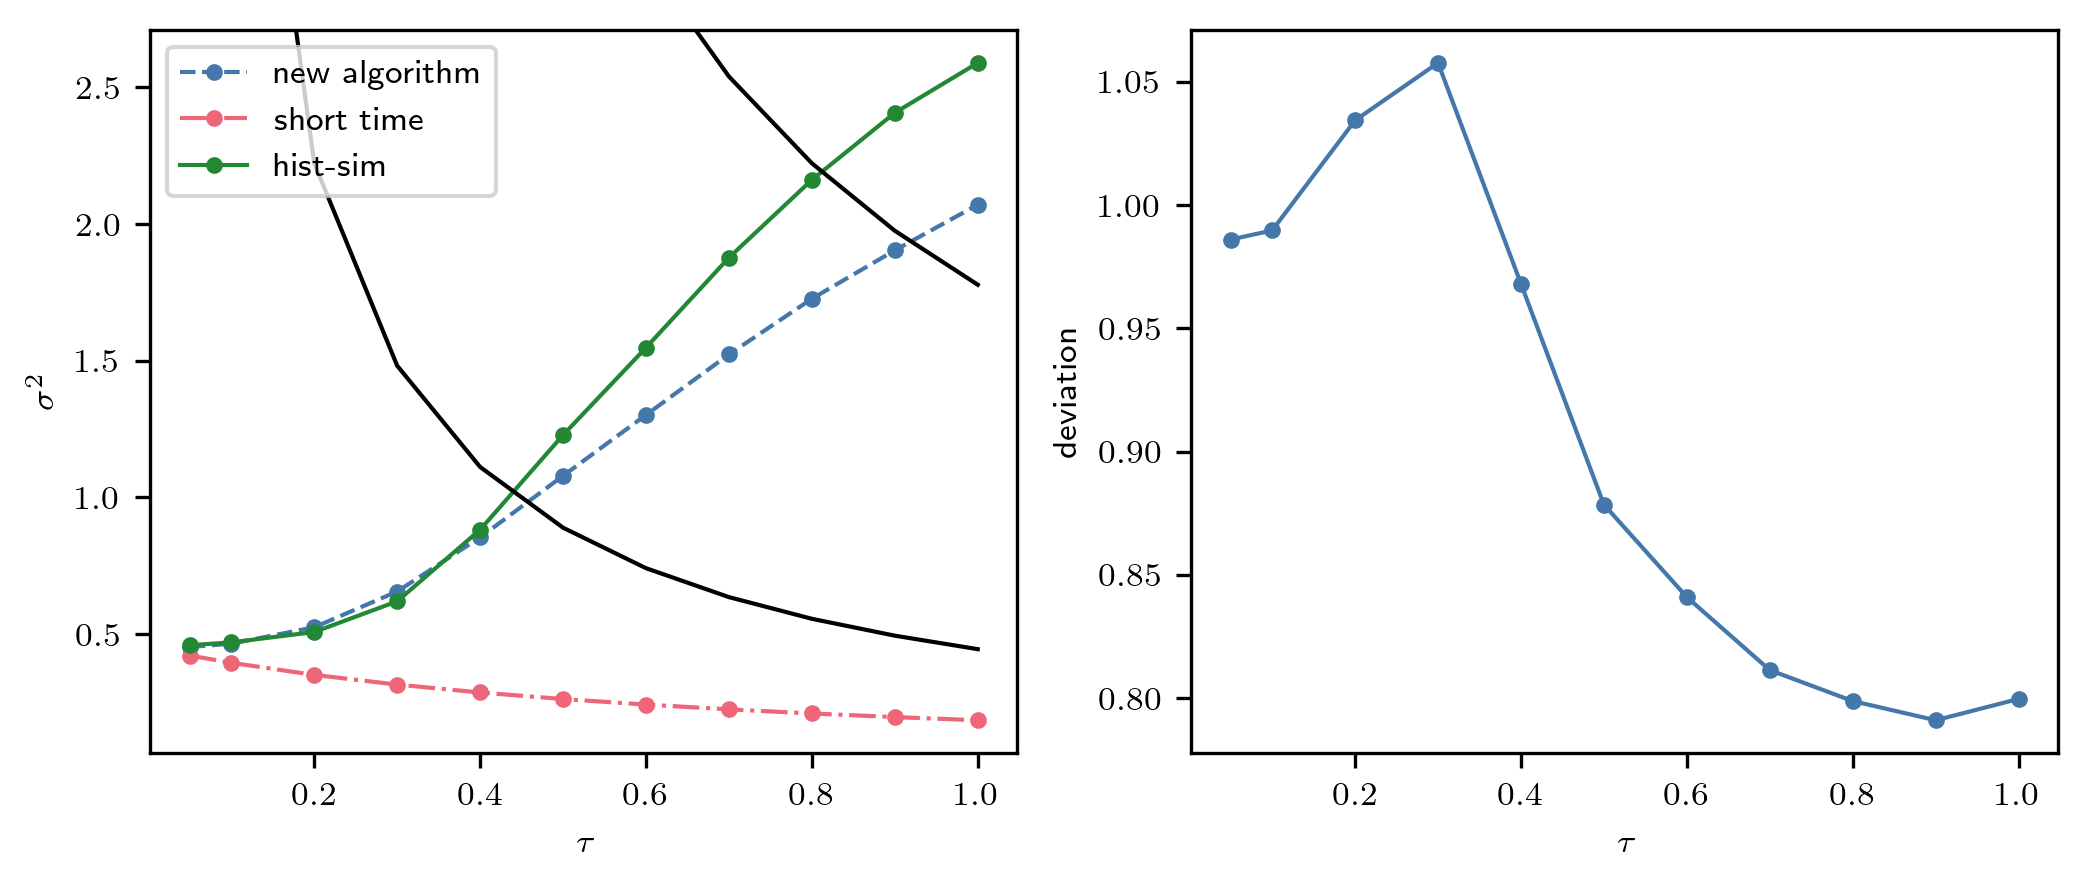

In [33]:
plt.figure(figsize=(7,3))
ax = plt.subplot(121)
#plt.plot(ltaus,sim_vars[:,0],'.-', label='sim')

plt.plot(ltaus,num_vars[:,0],'.--', label='new algorithm')



plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')

plt.plot(ltaus,sim_hist_vars[:,0],'.-', label='hist-sim')

#plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')
plt.ylim(*plt.ylim())
#auflösungslimit std same as div x0
plt.plot(ltaus, (2/3)**2*ltaus**(-1), color = 'black')
plt.plot(ltaus, (4/3)**2*ltaus**(-1), color = 'black')

ax = plt.subplot(122)
plt.plot(ltaus, num_vars[:,0]/sim_hist_vars[:,0], '.-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'deviation')

plt.tight_layout()
plt.savefig('graphics/x4variance.pdf')